# <center>*Risk Based Credit Decisioning Final Project*</center>

**Group Members:**

*Name - Suvidha Sharma*  
*Student ID: 02196543*

*Name - Nandan Singh Khanotiya*  
*Student ID: 02150422*

## Load packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')


##  Load and preprocess the dataset

In [2]:
# Step 2: Load and preprocess the dataset
data = pd.read_csv("C:/Users/DELL/Downloads/archive/ADM/credit_risk_dataset.csv")

# Check for duplicate rows
duplicate_rows = data[data.duplicated()]
print("Duplicate Rows:\n", duplicate_rows)

# Count the number of duplicate rows
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

# Remove duplicate rows
data = data.drop_duplicates().reset_index(drop=True)

# Save to a new CSV file (optional)
data.to_csv("C:/Users/DELL/Downloads/archive/ADM/datasetforproject.csv", index=False)

# Reload to mimic R's read again behavior
data = pd.read_csv("C:/Users/DELL/Downloads/archive/ADM/datasetforproject.csv")

# View number of rows
print(f"Number of rows in the dataset: {data.shape[0]}")


Duplicate Rows:
        person_age  person_income person_home_ownership  person_emp_length   
15975          23          42000                  RENT                5.0  \
15989          23          90000              MORTGAGE                7.0   
15995          24          48000              MORTGAGE                4.0   
16025          24          10000                  RENT                8.0   
16028          23         100000              MORTGAGE                7.0   
...           ...            ...                   ...                ...   
32010          42          39996              MORTGAGE                2.0   
32047          36         250000                  RENT                2.0   
32172          49         120000              MORTGAGE               12.0   
32259          39          40000                   OWN                4.0   
32279          43          11340                  RENT                4.0   

             loan_intent loan_grade  loan_amnt  loan_int_r

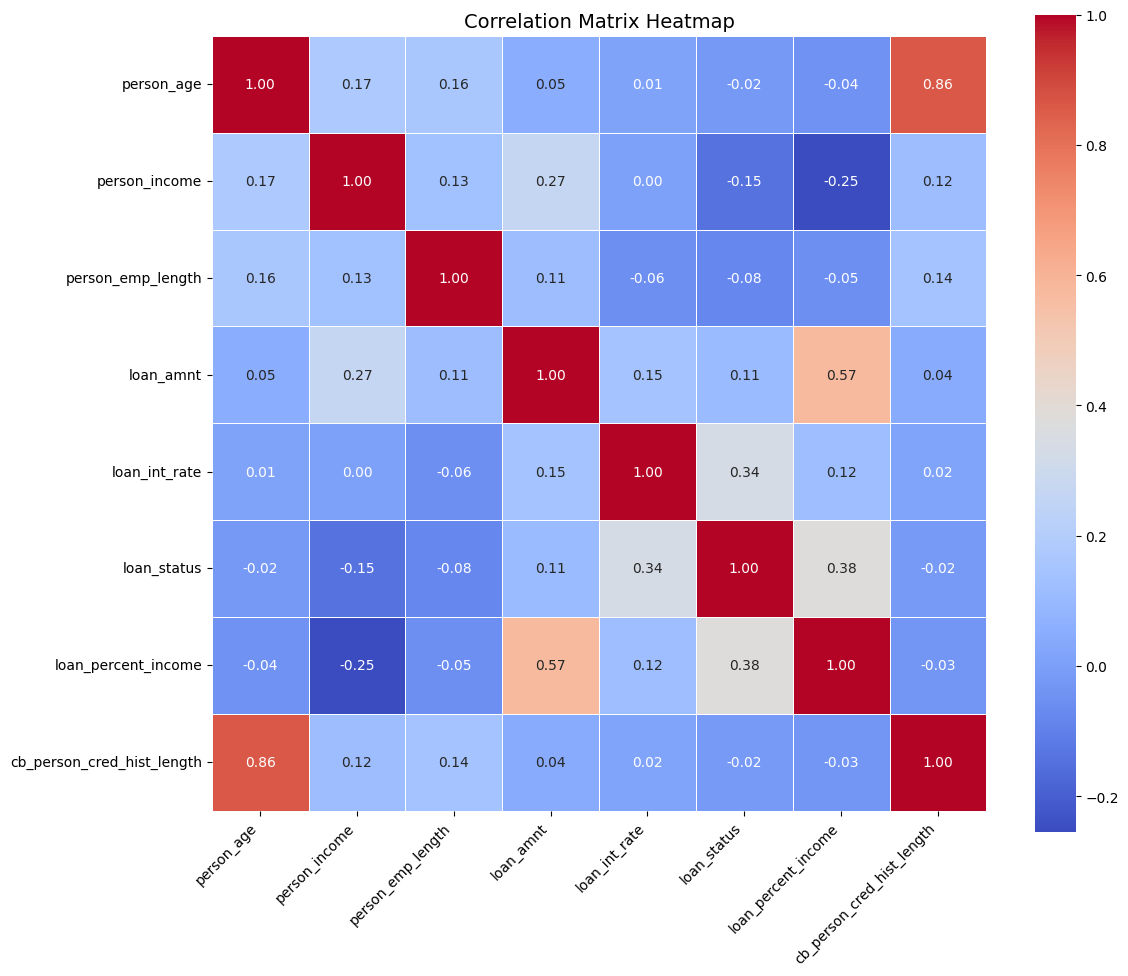

In [3]:
cor_matrix = data.corr(numeric_only=True)
# Visualize using seaborn heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix Heatmap", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Check for missing values

In [4]:
# Check missing values per column
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


## Preview selected columns and drop one

In [5]:
# Select and print some columns
print(data[['person_income', 'loan_amnt', 'loan_percent_income']].head())

# Drop 'loan_percent_income'
data.drop('loan_percent_income', axis=1, inplace=True)

# Save updated version
data.to_csv("C:/Users/DELL/Downloads/archive/ADM/datasetforproject.csv", index=False)
print(data.head())

# Print dataset dimensions
print(f"Dataset dimensions: {data.shape[0]} rows and {data.shape[1]} columns")

   person_income  loan_amnt  loan_percent_income
0          59000      35000                 0.59
1           9600       1000                 0.10
2           9600       5500                 0.57
3          65500      35000                 0.53
4          54400      35000                 0.55
   person_age  person_income person_home_ownership  person_emp_length   
0          22          59000                  RENT              123.0  \
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status   
0    PERSONAL          D      35000          16.02            1  \
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   

## Structure and summary of data

In [6]:
# View data types
print("Data structure:\n", data.dtypes)

# Summary statistics
print("Summary statistics:\n", data.describe(include='all'))

Data structure:
 person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object
Summary statistics:
           person_age  person_income person_home_ownership  person_emp_length   
count   32416.000000   3.241600e+04                 32416        31529.00000  \
unique           NaN            NaN                     4                NaN   
top              NaN            NaN                  RENT                NaN   
freq             NaN            NaN                 16378                NaN   
mean       27.747008   6.609164e+04                   NaN            4.79051   
std         6.354100   6.201558e+04               

## Visualize numeric data

Numeric Columns: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'cb_person_cred_hist_length']


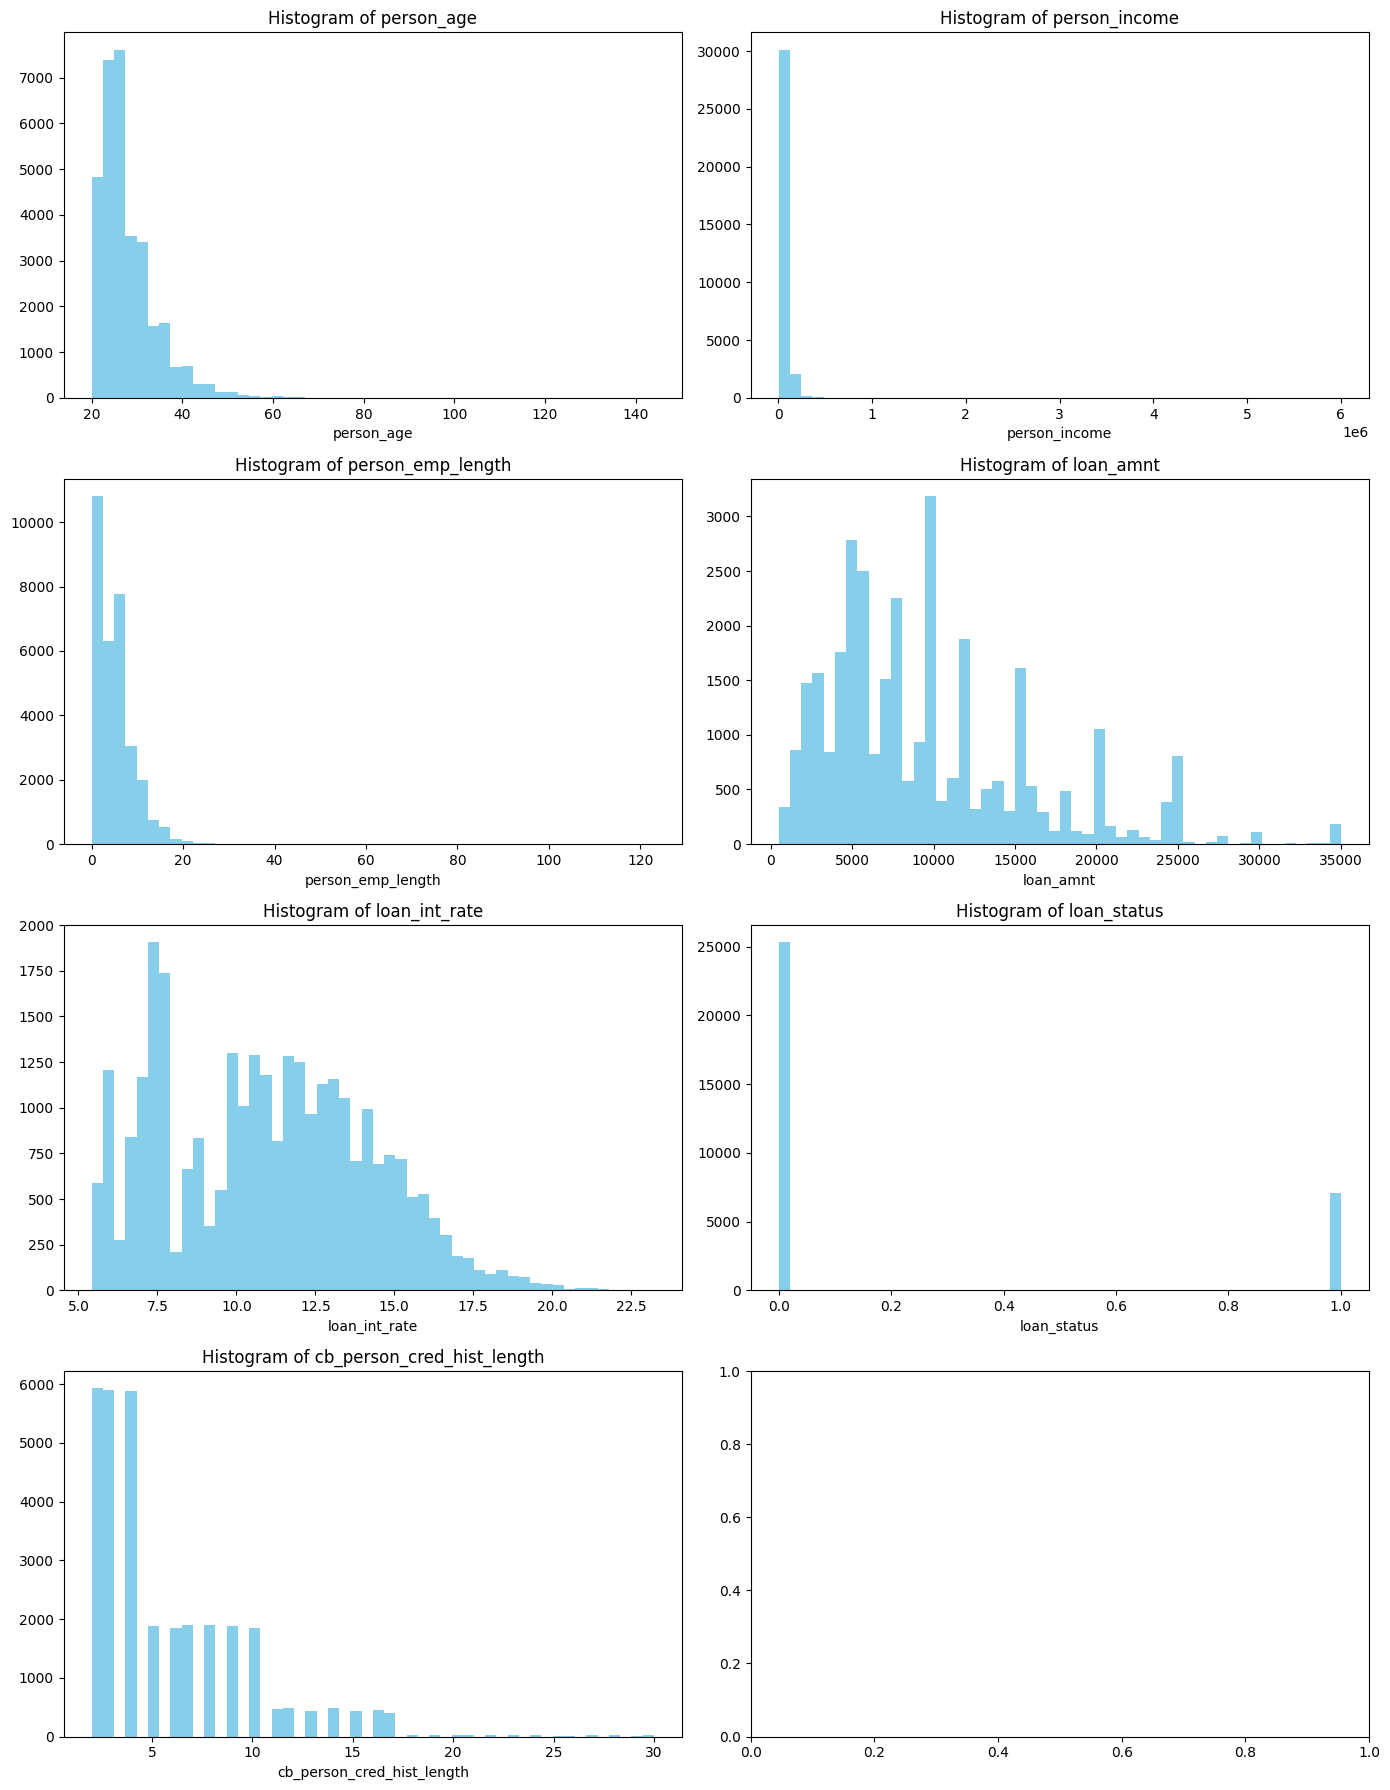

In [7]:
# Identify numeric columns
numeric_cols = data.select_dtypes(include=np.number).columns.tolist()
print("Numeric Columns:", numeric_cols)

# Plot histograms
fig, axs = plt.subplots(nrows=int(np.ceil(len(numeric_cols) / 2)), ncols=2, figsize=(14, 18))
axs = axs.flatten()
for i, col in enumerate(numeric_cols):
    axs[i].hist(data[col], bins=50, color='skyblue')
    axs[i].set_title(f"Histogram of {col}")
    axs[i].set_xlabel(col)
plt.tight_layout()
plt.show()

## Clean age and employment length values

In [8]:
# Remove records with age >= 80
data = data[data['person_age'] < 80]

# Save the modified dataset
data.to_csv("C:/Users/DELL/Downloads/archive/ADM/datasetforproject.csv", index=False)

print(f"New dataset dimensions after age filter: {data.shape}")

# Remove employment length > 65, keep NA
data = data[(data['person_emp_length'] <= 65) | (data['person_emp_length'].isna())]
data.to_csv("C:/Users/DELL/Downloads/archive/ADM/datasetforproject.csv", index=False)
print(f"New dataset dimensions after emp_length filter: {data.shape}")


New dataset dimensions after age filter: (32408, 11)
New dataset dimensions after emp_length filter: (32406, 11)


## Impute missing values and encode categoricals

In [9]:
# Impute missing values with median
data['person_emp_length'].fillna(data['person_emp_length'].median(), inplace=True)
data['loan_int_rate'].fillna(data['loan_int_rate'].median(), inplace=True)

# Confirm missing values are handled
print(data.isnull().sum())

# Encode categorical variables
label_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
label_encoders = {}
for col in label_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

print(data.head())
print("All columns:\n", data.columns)

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64
   person_age  person_income  person_home_ownership  person_emp_length   
1          21           9600                      2                5.0  \
2          25           9600                      0                1.0   
3          23          65500                      3                4.0   
4          24          54400                      3                8.0   
5          21           9900                      2                2.0   

   loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_status   
1            1           1       1000          11.14            0  \
2            3           2       5500          12.87

## Visualizations

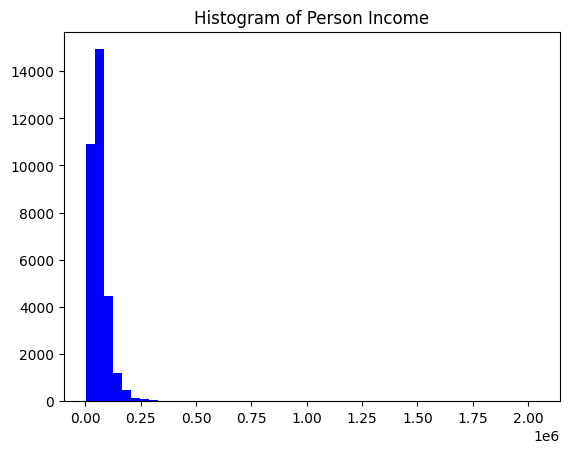

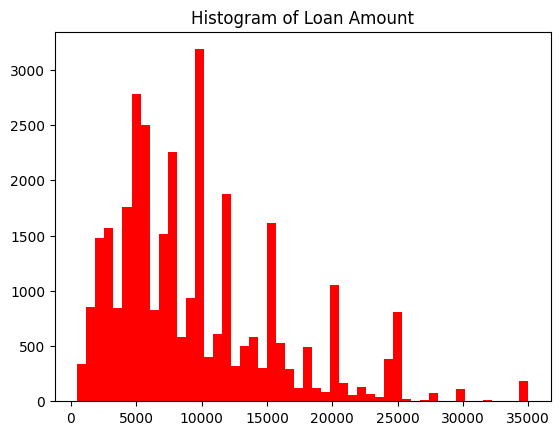

In [10]:
# Histograms
plt.hist(data['person_income'], bins=50, color='blue')
plt.title("Histogram of Person Income")
plt.show()

plt.hist(data['loan_amnt'], bins=50, color='red')
plt.title("Histogram of Loan Amount")
plt.show()

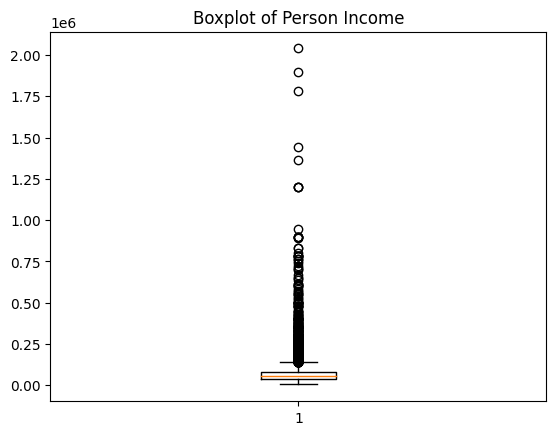

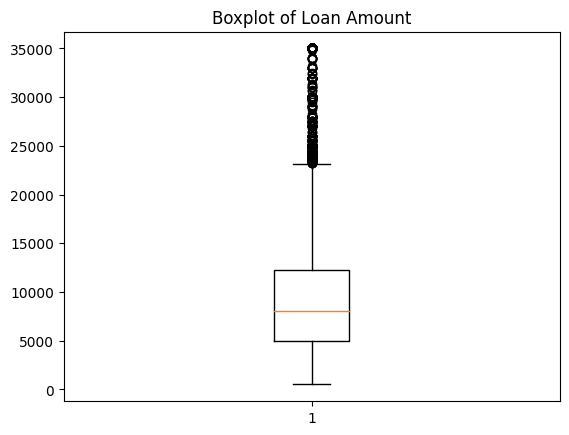

In [11]:
# Boxplots
plt.boxplot(data['person_income'])
plt.title("Boxplot of Person Income")
plt.show()

plt.boxplot(data['loan_amnt'])
plt.title("Boxplot of Loan Amount")
plt.show()

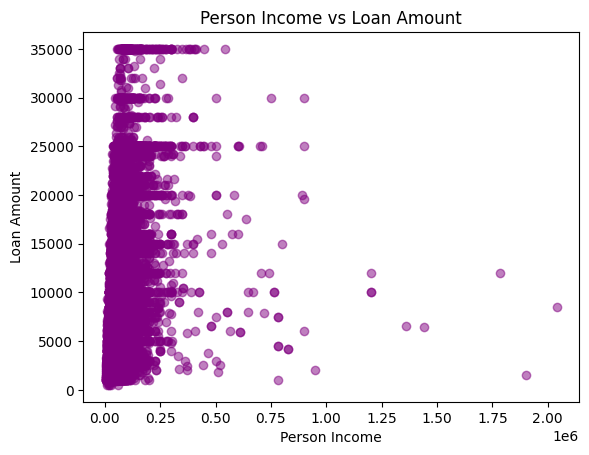

In [12]:
# Scatterplot
plt.scatter(data['person_income'], data['loan_amnt'], alpha=0.5, color='purple')
plt.title("Person Income vs Loan Amount")
plt.xlabel("Person Income")
plt.ylabel("Loan Amount")
plt.show()

## Correlation Matrix

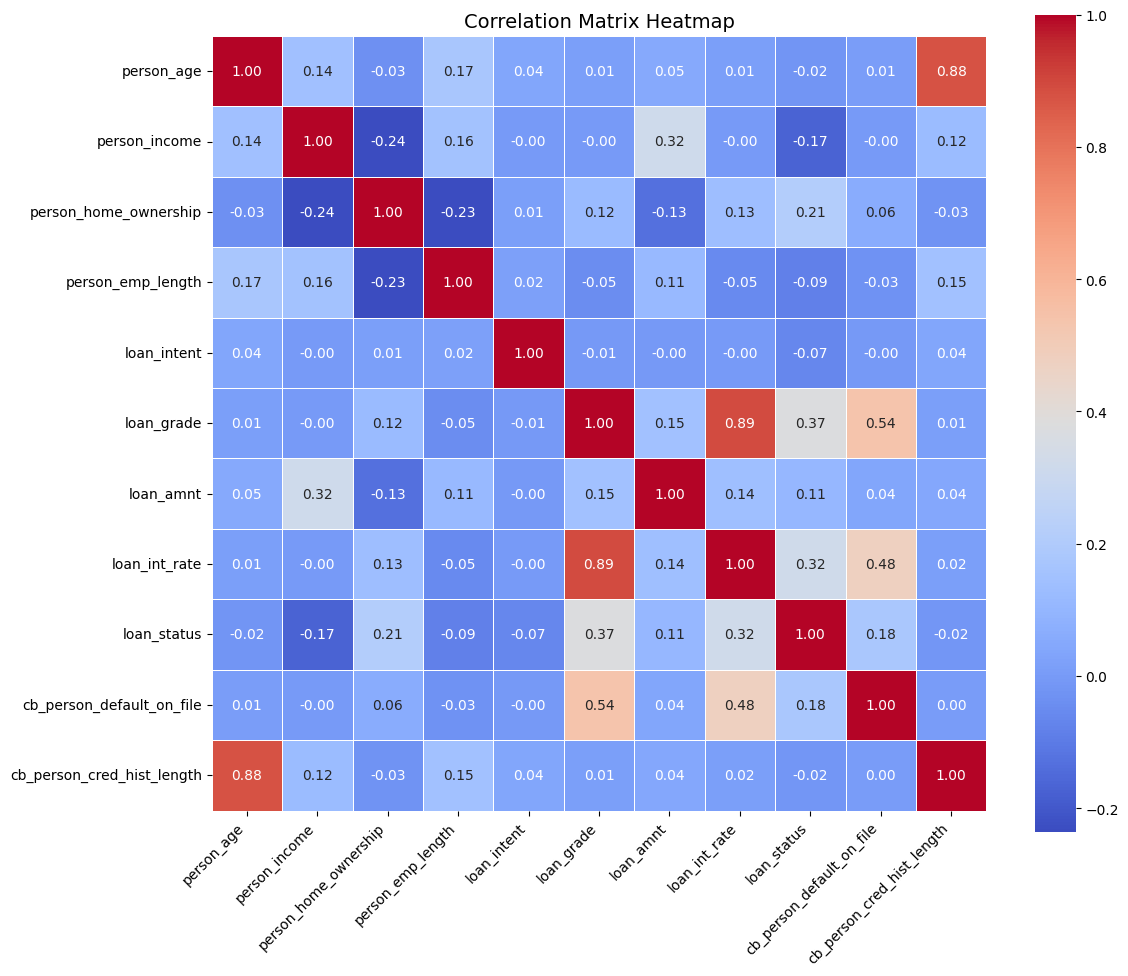

In [13]:
cor_matrix = data.corr(numeric_only=True)
# Visualize using seaborn heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix Heatmap", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Feature Matrix and Target Vector

In [14]:
# Separate features and target
X = data.drop('loan_status', axis=1)
y = data['loan_status']

# Convert to NumPy arrays if needed
X = X.values
y = y.values

## Train-Test Split

In [15]:
# Train-test split (80/20)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (25924, 10)
Test set size: (6482, 10)


## <font color = red>Random Forest Model<font/>

In [16]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
rf_model.fit(X_train, y_train)

# Feature importance
importances = rf_model.feature_importances_
print("Feature Importances:\n", importances)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Feature Importances:
 [0.05383836 0.25528214 0.07047377 0.07043899 0.08238552 0.11679026
 0.1676805  0.12911256 0.01076617 0.04323174]
Confusion Matrix:
 [[5006   61]
 [ 391 1024]]
Accuracy: 0.9302684356680037
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5067
           1       0.94      0.72      0.82      1415

    accuracy                           0.93      6482
   macro avg       0.94      0.86      0.89      6482
weighted avg       0.93      0.93      0.93      6482



##  Feature Importances from Random Forest

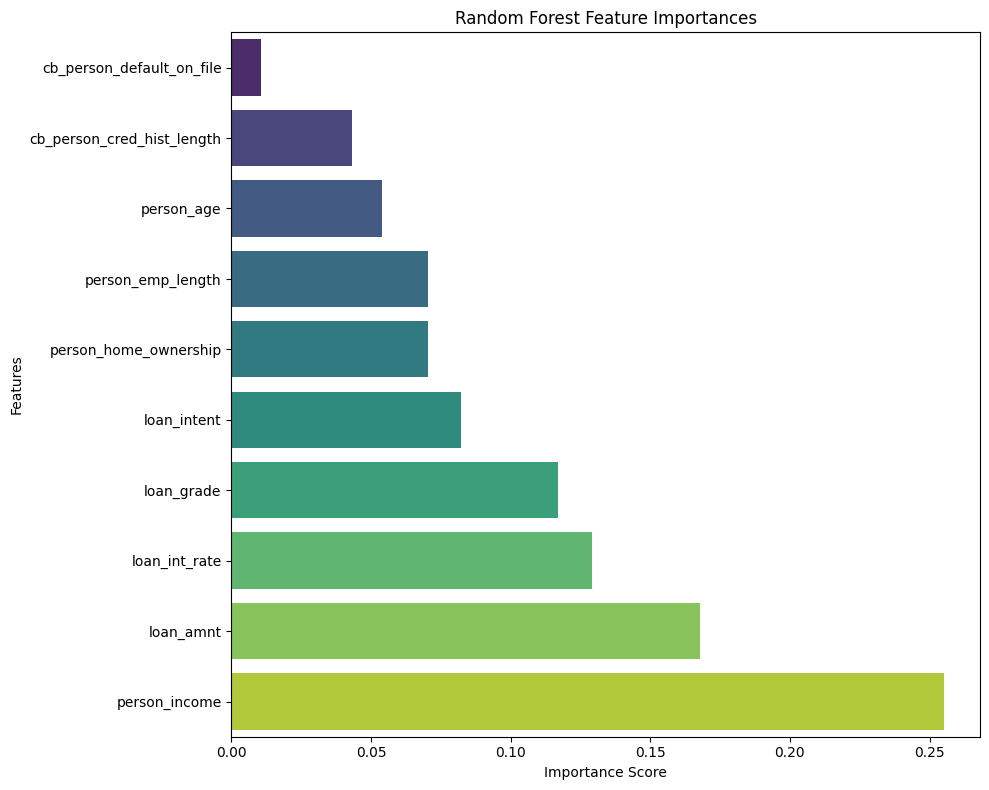

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Use column names from the original DataFrame
feature_names = data.drop('loan_status', axis=1).columns

# Create DataFrame for importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
})

# Sort values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


## Correlation Matrix Random Forest

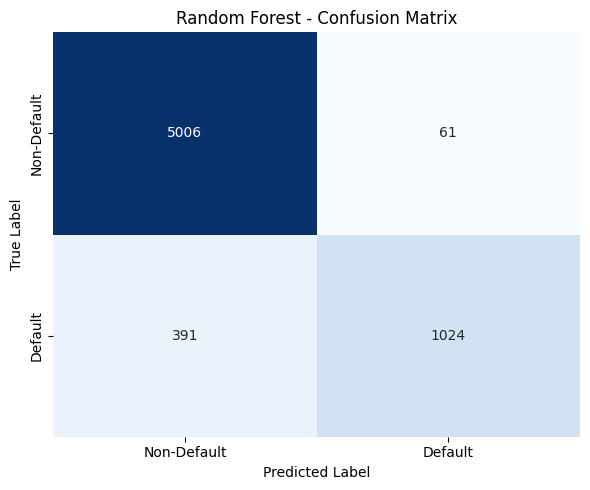

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Non-Default", "Default"],
            yticklabels=["Non-Default", "Default"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.show()

## Random Forest ROC & AUC

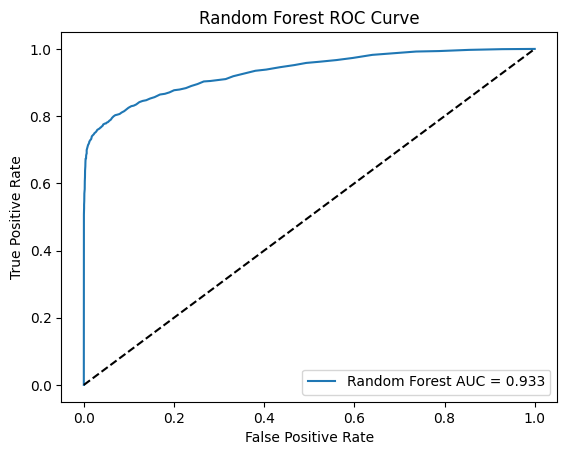

In [19]:
# ROC and AUC for Random Forest
rf_probs = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Random Forest AUC = %0.3f' % roc_auc_rf)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc="lower right")
plt.show()

## <font color = red>Decision Tree Model<font/>

In [20]:
# Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict
y_pred_dt = dt_model.predict(X_test)

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

Confusion Matrix:
 [[4620  447]
 [ 310 1105]]
Accuracy: 0.8832150570811478
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      5067
           1       0.71      0.78      0.74      1415

    accuracy                           0.88      6482
   macro avg       0.82      0.85      0.83      6482
weighted avg       0.89      0.88      0.89      6482



## Confusion Matrix Visualization (Decision Tree)

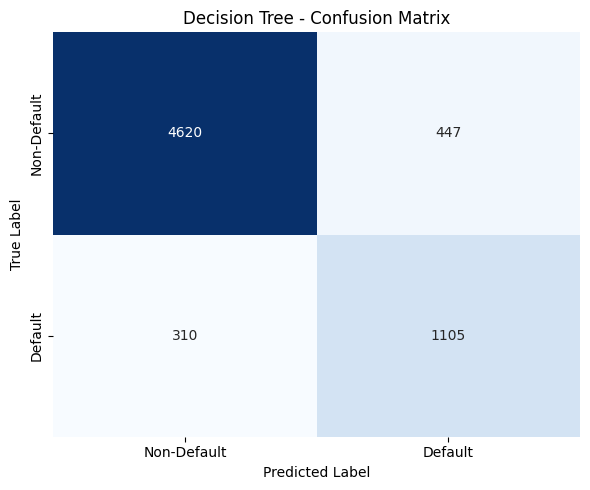

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Generate confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Non-Default", "Default"],
            yticklabels=["Non-Default", "Default"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Decision Tree - Confusion Matrix")
plt.tight_layout()
plt.show()

## Decision Tree ROC & AUC

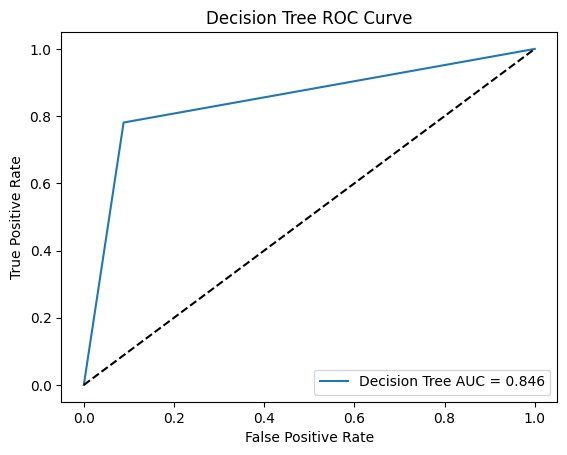

In [22]:
# ROC & AUC for Decision Tree
dt_probs = dt_model.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_probs)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure()
plt.plot(fpr_dt, tpr_dt, label='Decision Tree AUC = %0.3f' % roc_auc_dt)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree ROC Curve")
plt.legend(loc="lower right")
plt.show()

## <font color = red>Logistic Regression Model<font/>

In [23]:
# Train Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Predict
y_pred_log = log_model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))

Confusion Matrix:
 [[4818  249]
 [ 849  566]]
Accuracy: 0.8306078370873188
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90      5067
           1       0.69      0.40      0.51      1415

    accuracy                           0.83      6482
   macro avg       0.77      0.68      0.70      6482
weighted avg       0.82      0.83      0.81      6482



## Confusion Matrix Visualization (Logistic Regression)

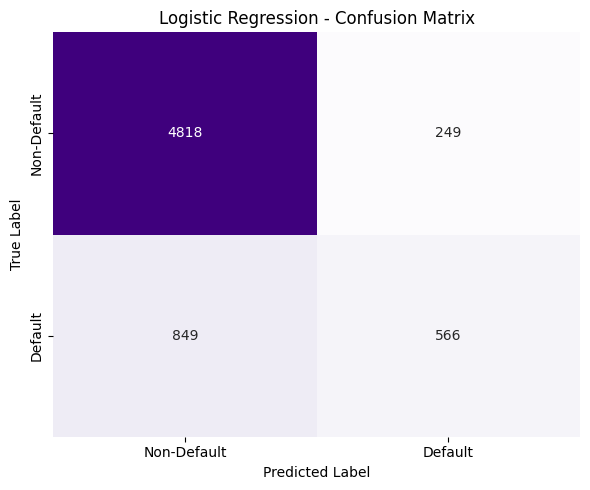

In [24]:
# Compute confusion matrix
cm_log = confusion_matrix(y_test, y_pred_log)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=["Non-Default", "Default"],
            yticklabels=["Non-Default", "Default"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Logistic Regression - Confusion Matrix")
plt.tight_layout()
plt.show()

## Logistic Regression ROC & AUC

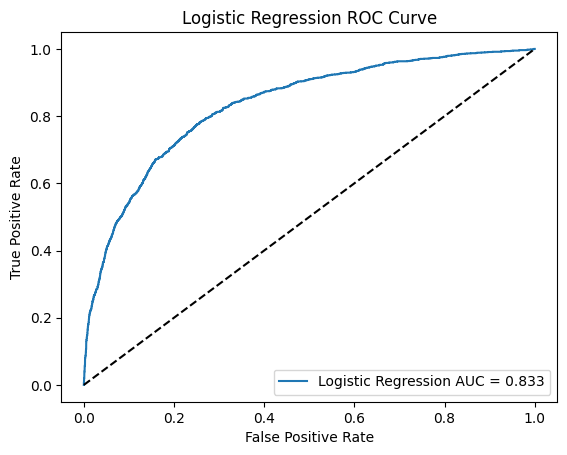

In [25]:
# ROC & AUC for Logistic Regression
log_probs = log_model.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
roc_auc_log = auc(fpr_log, tpr_log)

plt.figure()
plt.plot(fpr_log, tpr_log, label='Logistic Regression AUC = %0.3f' % roc_auc_log)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.legend(loc="lower right")
plt.show()

## <font color = red>Support Vector Machine (SVM) Model<font/>

In [26]:
# Ensure all categorical features are properly encoded again if needed
from sklearn.preprocessing import StandardScaler

# Standardizing features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM with RBF kernel and probability estimates
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predict with SVM
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

Confusion Matrix:
 [[4924  143]
 [ 661  754]]
Accuracy: 0.8759642085775995
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92      5067
           1       0.84      0.53      0.65      1415

    accuracy                           0.88      6482
   macro avg       0.86      0.75      0.79      6482
weighted avg       0.87      0.88      0.87      6482



## Confusion Matrix Visualization (SVM)

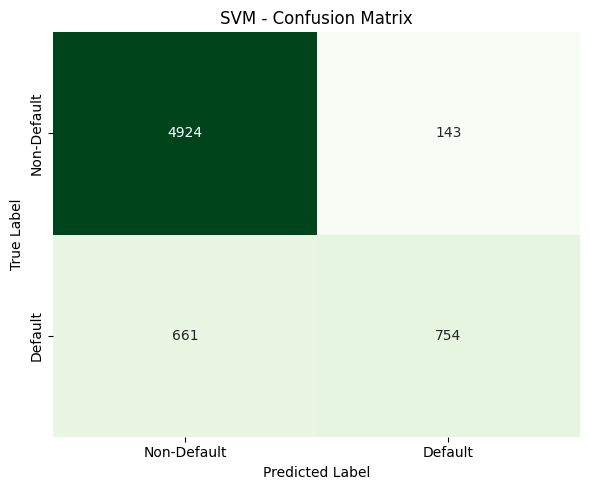

In [27]:
# Compute confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=["Non-Default", "Default"],
            yticklabels=["Non-Default", "Default"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("SVM - Confusion Matrix")
plt.tight_layout()
plt.show()

## SVM ROC & AUC

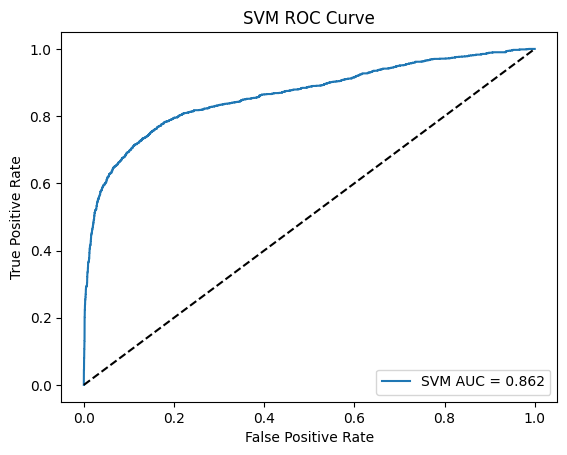

In [28]:
# Get probabilities for ROC
svm_probs = svm_model.predict_proba(X_test_scaled)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve
plt.figure()
plt.plot(fpr_svm, tpr_svm, label='SVM AUC = %0.3f' % roc_auc_svm)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve")
plt.legend(loc="lower right")
plt.show()


## <font color = red>XGBoost Model with One-Hot Encoding & Upsampling</font>

In [29]:
# Reload clean data and prep again for XGBoost
df = pd.read_csv("C:/Users/DELL/Downloads/archive/ADM/datasetforproject.csv")

# Label encode target
df['loan_status'] = df['loan_status'].astype(int)

# Separate features and target
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# One-hot encode using pandas
X_encoded = pd.get_dummies(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=123)

# Upsample using RandomOverSampler
ros = RandomOverSampler(random_state=123)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Check new class distribution
print("Class distribution after upsampling:", np.bincount(y_resampled))

Class distribution after upsampling: [20268 20268]


##  Train XGBoost with GridSearchCV

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 1}
Confusion Matrix:
 [[4825  225]
 [ 329 1103]]
Accuracy: 0.9145325516815798
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      5050
           1       0.83      0.77      0.80      1432

    accuracy                           0.91      6482
   macro avg       0.88      0.86      0.87      6482
weighted avg       0.91      0.91      0.91      6482



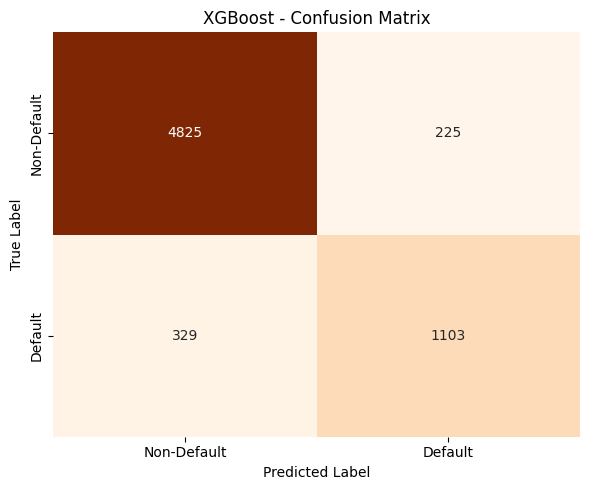

In [30]:
# Train XGBoost model
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define parameter grid
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [2, 4],
    'learning_rate': [0.3],
    'subsample': [1],
    'colsample_bytree': [1],
    'min_child_weight': [1]
}

# Use GridSearchCV for tuning
grid_cv = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
                       scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

# Fit on upsampled data
grid_cv.fit(X_resampled, y_resampled)

# Best model
print("Best parameters:", grid_cv.best_params_)
best_xgb = grid_cv.best_estimator_

# Predict on test data
y_pred_xgb = best_xgb.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=["Non-Default", "Default"],
            yticklabels=["Non-Default", "Default"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost - Confusion Matrix")
plt.tight_layout()
plt.show()

## XGBoost ROC & AUC

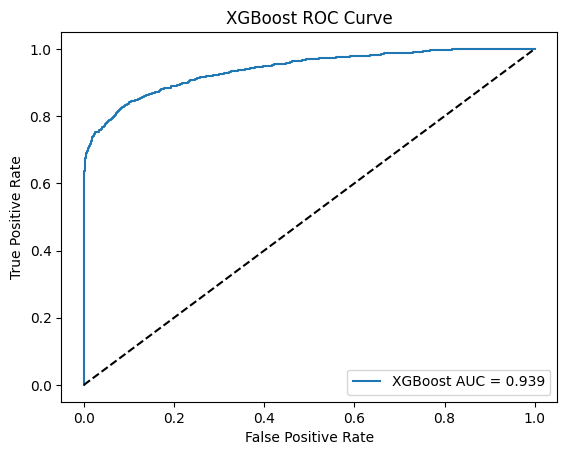

In [31]:
# Predict probabilities for ROC
xgb_probs = best_xgb.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curve
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost AUC = %0.3f' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend(loc="lower right")
plt.show()

##  XGBoost Feature Importance Visualization

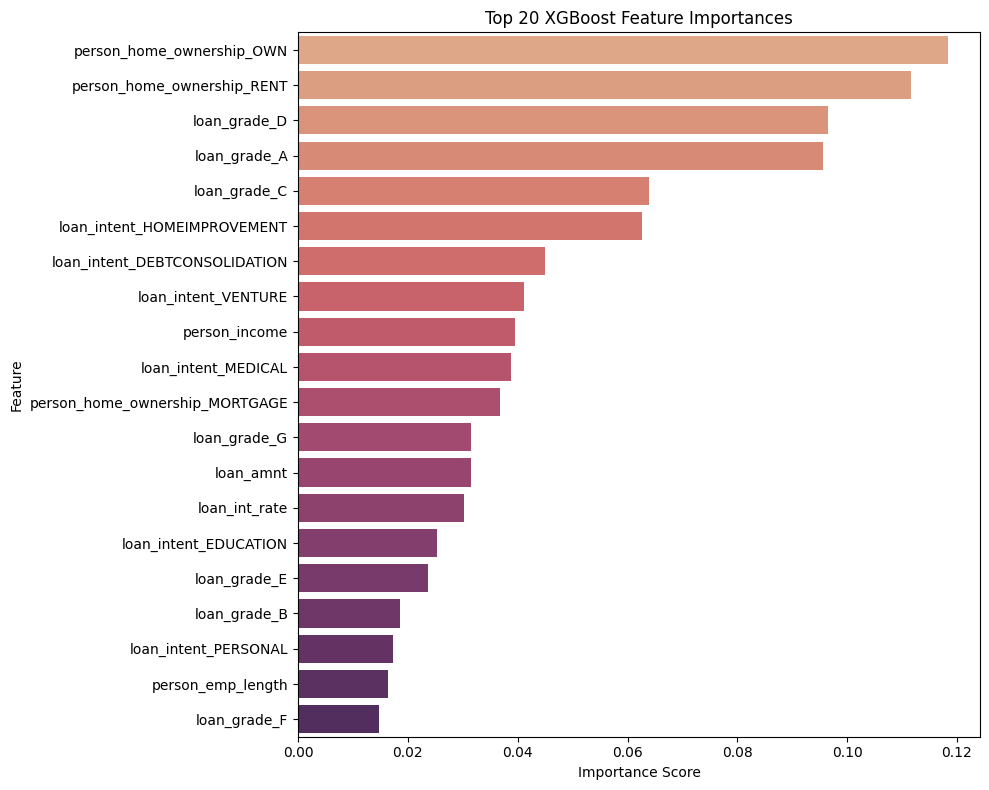

In [32]:
# Get feature importances from best XGBoost model
xgb_importances = best_xgb.feature_importances_
xgb_feature_names = X_encoded.columns  # these match the one-hot encoded columns

# Create a DataFrame for visualization
feat_imp_df = pd.DataFrame({
    'Feature': xgb_feature_names,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

# Plot top 20 features (adjust if you want more/less)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20), palette='flare')
plt.title("Top 20 XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Model Performance Visualization:

Model Evaluation Summary Table:


,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Random Forest,0.93,0.94,0.86,0.89,0.933
1,Decision Tree,0.88,0.82,0.85,0.83,0.846
2,Logistic Regression,0.83,0.77,0.68,0.70,0.833
3,SVM,0.88,0.86,0.75,0.79,0.862
4,XGBoost,0.91,0.88,0.86,0.87,0.939


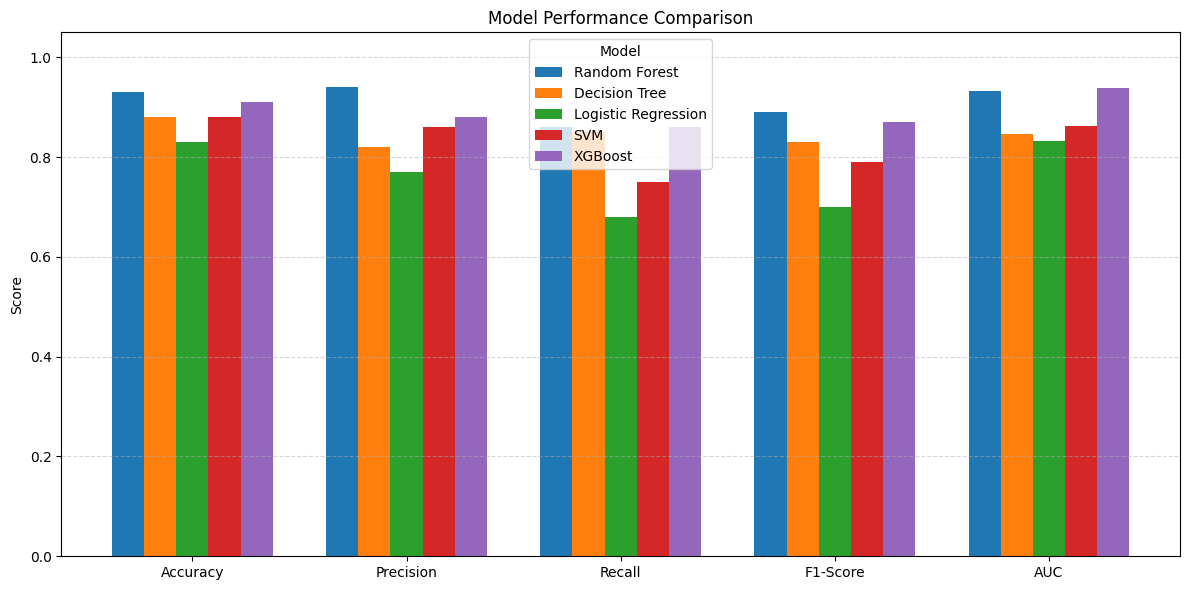

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Model metrics
data = {
    'Model': ['Random Forest', 'Decision Tree', 'Logistic Regression', 'SVM', 'XGBoost'],
    'Accuracy': [0.93, 0.88, 0.83, 0.88, 0.91],
    'Precision': [0.94, 0.82, 0.77, 0.86, 0.88],
    'Recall': [0.86, 0.85, 0.68, 0.75, 0.86],
    'F1-Score': [0.89, 0.83, 0.70, 0.79, 0.87],
    'AUC': [0.933, 0.846, 0.833, 0.862, 0.939]
}

# Create DataFrame
df = pd.DataFrame(data)

# Show table in notebook
from IPython.display import display
print("Model Evaluation Summary Table:")
display(df)

# Melt data for plotting
df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(12, 6))
metrics = df_melted['Metric'].unique()
x = np.arange(len(metrics))
width = 0.15

# Plot one bar for each model
for i, model in enumerate(df['Model']):
    model_scores = df_melted[df_melted['Model'] == model]['Score']
    plt.bar(x + i * width, model_scores, width=width, label=model)

# Formatting
plt.xticks(x + width * 2, metrics)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.ylim(0, 1.05)
plt.legend(title="Model")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()